# Import librerie

In [19]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle

import matplotlib.pyplot as plt
import glob
from shapely.geometry import Point, Polygon, LineString
import json
import re

from fuzzywuzzy import fuzz 
from fuzzywuzzy import process 

import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm
grad_b = cm.Blues(np.linspace(0,1,6))

In [20]:
def cambio_coordinate(ref, longitudine, latitudine, inxy='epsg:4326', outxy='epsg:32632'):
    from pyproj import Proj, transform

    # the crs of the point (in this case GPS Long/Lat)
    inProj =  Proj(init=inxy)

    # the desired crs (in this case Lambert, French crs)
    outProj = Proj(init=outxy)

    # project the coordinates in the new system.
    xnew,ynew = transform(inProj,outProj, longitudine, latitudine)
   
    df = pd.DataFrame(data=ref)
    df['lon'] = xnew
    df['lat'] = ynew
    
    geometry = [Point(xy) for xy in zip(df["lon"], df["lat"])]
    geodata = gpd.GeoDataFrame(df, geometry=geometry)
    geodata = geodata.drop(columns=['lon', 'lat'])
    
    return geodata

In [21]:
path_centri =  "data/ASC2011_WGS84.shp"
geo_centri = gpd.read_file(path_centri)
path_regioni =  "data/Reg01012019_g_WGS84.shp"
geo_regioni = gpd.read_file(path_regioni)
path_comuni =  "data/Com01012019_g_WGS84.shp"
geo_comuni = gpd.read_file(path_comuni)

# Pendolari Ferroviari

In [22]:
# stazioni
path_name =  "data/stazioni_ferroviarie_it.csv"
stazioni = pd.read_csv(path_name, sep=";", encoding="ISO-8859-1", low_memory=False)
stazioni = stazioni[["Nome", "Longitudine", "Latitudine"]]
stazioni = cambio_coordinate(stazioni, stazioni["Longitudine"].values, stazioni["Latitudine"].values, inxy='epsg:4326', outxy='epsg:32632')

pendolari = pd.read_csv( "data/linee_pendolari_2017.csv", sep=";")

In [23]:
path_name =  "data/Aeroporti-Italiani.csv"
aero = pd.read_csv(path_name, sep=";", encoding="ISO-8859-1", low_memory=False)
aero = aero[["Denominazione", "Comune", "Provincia", "DO_Y", "DO_X"]]
aero["Provincia"] = aero["Provincia"].str.capitalize()
aero = aero.rename(columns={"Denominazione":"Nome", "DO_Y":"Latitudine", "DO_X":"Longitudine"})

aero = cambio_coordinate(aero, aero["Longitudine"].values, aero["Latitudine"].values, inxy='epsg:4326', outxy='epsg:32632')

In [24]:
staz = []

for st in pendolari["Tratta Ferroviaria"]:
    staz += st.split("-")
    
staz = [st.split(" (")[0] for st in staz]
staz = stazioni[stazioni.Nome.isin(staz)]


Mappa geolocalizzata degli aereoporti e delle stazioni ferroviarie con evidenza dei capolinea delle tratte con più di 20k passeggeri al giorno

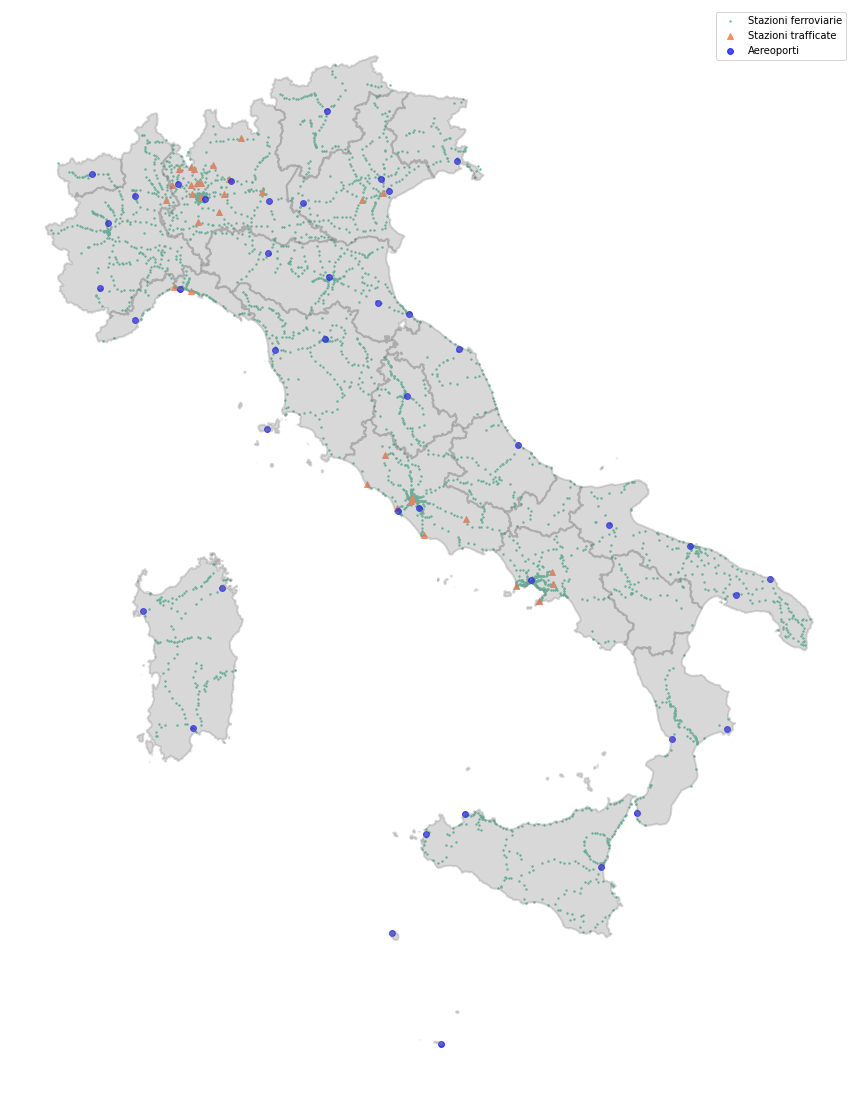

In [25]:
fig, ax = plt.subplots(figsize = (20,20))
stazioni.plot(ax=ax, markersize=2, color='#66c2a5')
staz.plot(ax=ax, markersize=35, marker="^", color='#fc8d62')
aero.plot(ax=ax, markersize=35, marker="o", alpha=0.7, color='blue')

geo_regioni.plot(ax=ax, color='grey', edgecolor='grey', alpha=0.3, linewidth=2)
plt.legend(["Stazioni ferroviarie", "Stazioni trafficate", "Aereoporti"])
ax.axis('off')
plt.show()

# Tratte aeree

In [8]:
# aeroporti

In [9]:
tratte_aeree = pd.read_csv( "data/Traffico_aereo_nazionale_2017_it.csv", sep=";")
tratte_aeree.head(10)

,Origine,Destinazione,Passeggeri
0,Catania,Roma Fiumicino,1016262
1,Roma Fiumicino,Catania,991516
2,Roma Fiumicino,Palermo,799435
3,Palermo,Roma Fiumicino,796016
4,Milano Linate,Roma Fiumicino,597754
5,Roma Fiumicino,Milano Linate,585999
6,Catania,Milano Malpensa,477510
7,Milano Malpensa,Catania,473521
8,Cagliari,Roma Fiumicino,467938
9,Roma Fiumicino,Cagliari,457099


In [10]:
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process 

tratte_aeree["dep_lat"] = 0
tratte_aeree["dep_lon"] = 0 
tratte_aeree["des_lat"] = 0
tratte_aeree["des_lon"] = 0 

for aeroporto in tratte_aeree.Origine:
    tmp = process.extractOne(aeroporto, aero.Comune)
    lat = aero[aero.Comune == tmp[0]].Latitudine.values
    lon = aero[aero.Comune == tmp[0]].Longitudine.values
    tratte_aeree.loc[tratte_aeree.Origine == aeroporto, "dep_lat"] = lat
    tratte_aeree.loc[tratte_aeree.Origine == aeroporto, "dep_lon"] = lon
    tratte_aeree.loc[tratte_aeree.Origine == aeroporto, "Origine"] = tmp[0]

for aeroporto in tratte_aeree.Destinazione:
    tmp = process.extractOne(aeroporto, aero.Comune)
    lat = aero[aero.Comune == tmp[0]].Latitudine.values
    lon = aero[aero.Comune == tmp[0]].Longitudine.values
    tratte_aeree.loc[tratte_aeree.Destinazione == aeroporto, "des_lat"] = lat
    tratte_aeree.loc[tratte_aeree.Destinazione == aeroporto, "des_lon"] = lon
    tratte_aeree.loc[tratte_aeree.Destinazione == aeroporto, "Destinazione"] = tmp[0]

In [11]:
dep_aeree = cambio_coordinate(tratte_aeree, tratte_aeree["dep_lon"].values, tratte_aeree["dep_lat"].values, inxy='epsg:4326', outxy='epsg:32632')
des_aeree = cambio_coordinate(tratte_aeree, tratte_aeree["des_lon"].values, tratte_aeree["des_lat"].values, inxy='epsg:4326', outxy='epsg:32632')

lines = []
passengers = []
count = 1
for dep, des in zip(dep_aeree.geometry, des_aeree.geometry):
    if count%2 and count<70:
        lines.append(LineString([dep, des]))
        passengers.append(dep_aeree.Passeggeri[count])
    count +=1
linee_aeree = gpd.GeoDataFrame(passengers, geometry=lines, columns=["Passeggeri"])

Tratte aeree passeggeri nazionali con più di 50k passeggeri l'anno

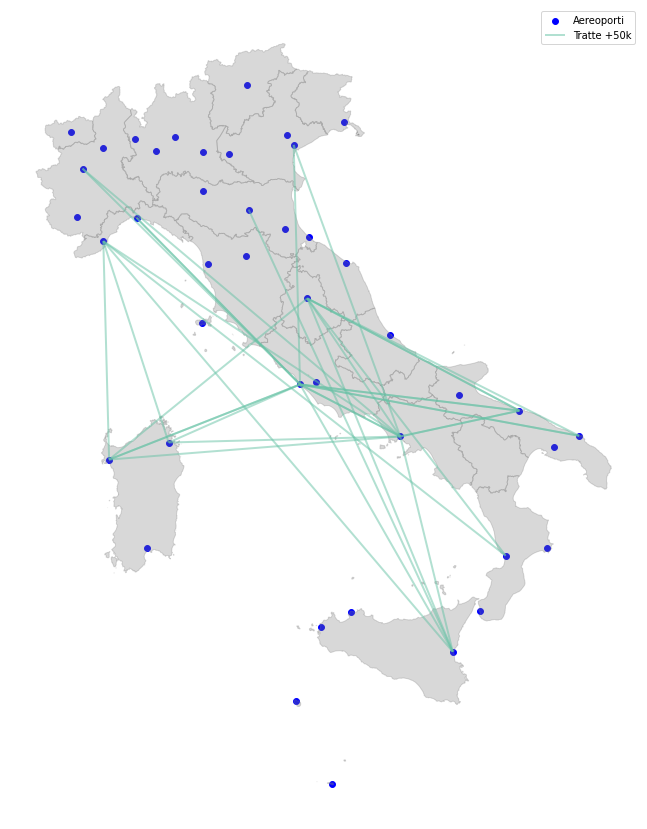

In [26]:
fig, ax = plt.subplots(figsize = (15,15))
aero.plot(ax=ax, markersize=35, marker="o", color='blue')
linee_aeree.plot(ax=ax, color='#66c2a5', alpha=0.5, linewidth=2)

geo_regioni.plot(ax=ax, color='grey', edgecolor='grey', alpha=0.3, linewidth=1)
plt.legend(["Aereoporti", "Tratte +50k"])
ax.axis('off')
plt.show()

# Composizione classi scolastiche

In [13]:
path_name =  "data/scuole_classi_totale.csv"
classi = pd.read_csv(path_name, sep=";", encoding="ISO-8859-1", low_memory=False)

classi.replace("Valle d'Aosta/VallÃ©e d'Aoste", "Valle d'Aosta", inplace=True)
classi.set_index("Regione", inplace=True)

classi.head()

,scuole_infanzia,classi_infanzia,iscritti_infanzia,scuole_primaria,classi_primaria,iscritti_primaria,scuole_secondariaI,classi_secondariaI,iscritti_secondariaI,scuole_secondariaII,classi_secondariaII,iscritti_secondariaII
Regione,,,,,,,,,,,,
Piemonte,1648,4696,104105,1343,10020,188516,571,5571,116875,402,8311,174002
Valle d'Aosta,90,177,3172,84,394,5888,21,177,3600,27,291,5594
Liguria,541,1475,32611,465,3211,59997,193,1785,38344,139,2833,61284
Lombardia,3064,10809,251775,2411,23146,472375,1289,13239,288170,996,18637,396638
Trentino Alto Adige,610,1494,31921,541,3362,54659,175,1672,34087,93,2266,41290


In [14]:
plt.style.use('seaborn-dark')

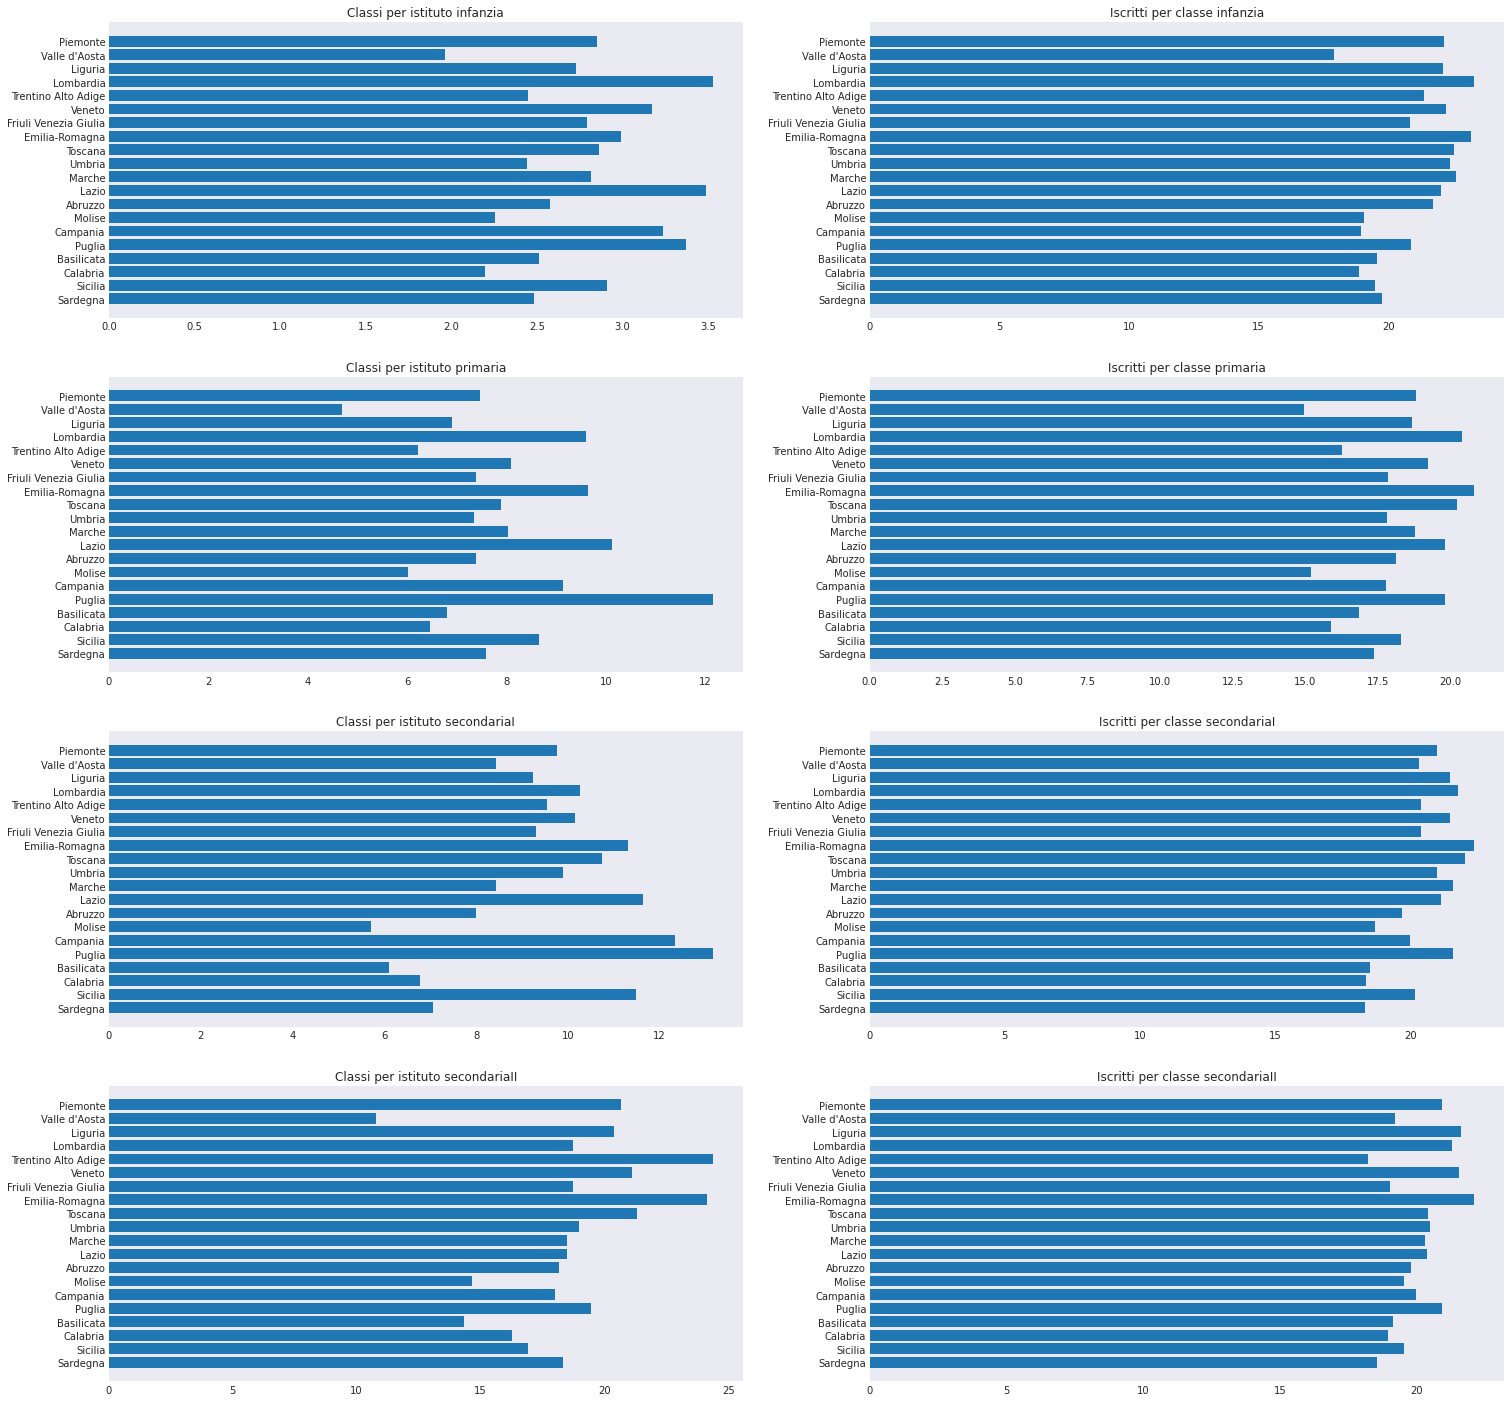

In [15]:
fig = plt.figure(figsize=(25,25))

plt.subplot(4,2,1)
plt.barh(classi.index[::-1], classi.classi_infanzia[::-1]/classi.scuole_infanzia[::-1])
plt.title("Classi per istituto infanzia")

plt.subplot(4,2,2)
plt.barh(classi.index[::-1], classi.iscritti_infanzia[::-1]/classi.classi_infanzia[::-1])
plt.title("Iscritti per classe infanzia")

plt.subplot(4,2,3)
plt.barh(classi.index[::-1], classi.classi_primaria[::-1]/classi.scuole_primaria[::-1])
plt.title("Classi per istituto primaria")

plt.subplot(4,2,4)
plt.barh(classi.index[::-1], classi.iscritti_primaria[::-1]/classi.classi_primaria[::-1])
plt.title("Iscritti per classe primaria")

plt.subplot(4,2,5)
plt.barh(classi.index[::-1], classi.classi_secondariaI[::-1]/classi.scuole_secondariaI[::-1])
plt.title("Classi per istituto secondariaI")

plt.subplot(4,2,6)
plt.barh(classi.index[::-1], classi.iscritti_secondariaI[::-1]/classi.classi_secondariaI[::-1])
plt.title("Iscritti per classe secondariaI")

plt.subplot(4,2,7)
plt.barh(classi.index[::-1], classi.classi_secondariaII[::-1]/classi.scuole_secondariaII[::-1])
plt.title("Classi per istituto secondariaII")

plt.subplot(4,2,8)
plt.barh(classi.index[::-1], classi.iscritti_secondariaII[::-1]/classi.classi_secondariaII[::-1])
plt.title("Iscritti per classe secondariaII")

plt.show()

# Dimensione imprese

In [16]:
path_name =  "data/imprese_taglia_regione.csv"
imprese_treg = pd.read_csv(path_name, sep=";", encoding="ISO-8859-1", low_memory=False)

imprese_treg.replace("Valle d'Aosta/VallÃ©e d'Aoste", "Valle d'Aosta", inplace=True)
imprese_treg.set_index("Regione", inplace=True)
imprese_treg = imprese_treg[imprese_treg.columns[:-1]] / 100
imprese_treg

,Imprese_0_9,Imprese_10_49,Imprese_50_249,Imprese_250,Addetti_0_9,Addetti_10_49,Addetti_50_249,Addetti_250
Regione,,,,,,,,
Piemonte,0.954,0.040,0.005,0.001,0.432,0.176,0.127,0.266
Valle d'Aosta,0.959,0.036,0.005,0.001,0.584,0.188,0.143,0.085
Liguria,0.963,0.033,0.003,0.001,0.546,0.170,0.096,0.187
Lombardia,0.941,0.050,0.007,0.001,0.352,0.192,0.155,0.302
Trentino-Alto Adige,0.932,0.059,0.007,0.001,0.440,0.246,0.168,0.145
Veneto,0.940,0.053,0.007,0.001,0.425,0.229,0.152,0.194
Friuli Venezia Giulia,0.946,0.047,0.006,0.001,0.420,0.200,0.139,0.241
Emilia-Romagna,0.945,0.048,0.006,0.001,0.412,0.204,0.140,0.245
Toscana,0.951,0.045,0.004,0.001,0.529,0.225,0.108,0.138


In [17]:
path_name =  "data/imprese_regione.csv"
imprese_reg = pd.read_csv(path_name, sep=";", encoding="ISO-8859-1", low_memory=False)

imprese_reg.replace("Valle d'Aosta/VallÃ©e d'Aoste", "Valle d'Aosta", inplace=True)
imprese_reg.set_index("Regione", inplace=True)

imprese_reg

,Imprese_VA,Imprese_Perc,Addetti_VA,Addetti_Perc
Regione,,,,
Piemonte,325839,7.4,1311011,7.9
Valle d'Aosta,11221,0.3,36426,0.2
Liguria,124011,2.8,406025,2.4
Lombardia,814867,18.6,3896410,23.4
Trentino-Alto Adige,85138,1.9,361303,2.2
Veneto,394451,9.0,1654487,9.9
Friuli Venezia Giulia,83702,1.9,351875,2.1
Emilia-Romagna,368153,8.4,1551470,9.3
Toscana,322887,7.4,1101852,6.6


In [18]:
pd.options.display.float_format = '{:.0f}'.format

imprese_cols = ["Imprese_0_9","Imprese_10_49","Imprese_50_249","Imprese_250"]
imprese_treg[imprese_cols] = imprese_treg[imprese_cols].mul(imprese_reg.Imprese_VA, axis=0)

addetti_cols = ["Addetti_0_9","Addetti_10_49","Addetti_50_249","Addetti_250"]
imprese_treg[addetti_cols] = imprese_treg[addetti_cols].mul(imprese_reg.Addetti_VA, axis=0)

imprese_treg

,Imprese_0_9,Imprese_10_49,Imprese_50_249,Imprese_250,Addetti_0_9,Addetti_10_49,Addetti_50_249,Addetti_250
Regione,,,,,,,,
Piemonte,310850,13034,1629,326,566357,230738,166498,348729
Valle d'Aosta,10761,404,56,11,21273,6848,5209,3096
Liguria,119423,4092,372,124,221690,69024,38978,75927
Lombardia,766790,40743,5704,815,1371536,748111,603944,1176716
Trentino-Alto Adige,79349,5023,596,85,158973,88881,60699,52389
Veneto,370784,20906,2761,394,703157,378878,251482,320970
Friuli Venezia Giulia,79182,3934,502,84,147788,70375,48911,84802
Emilia-Romagna,347905,17671,2209,368,639206,316500,217206,380110
Toscana,307066,14530,1292,323,582880,247917,119000,152056


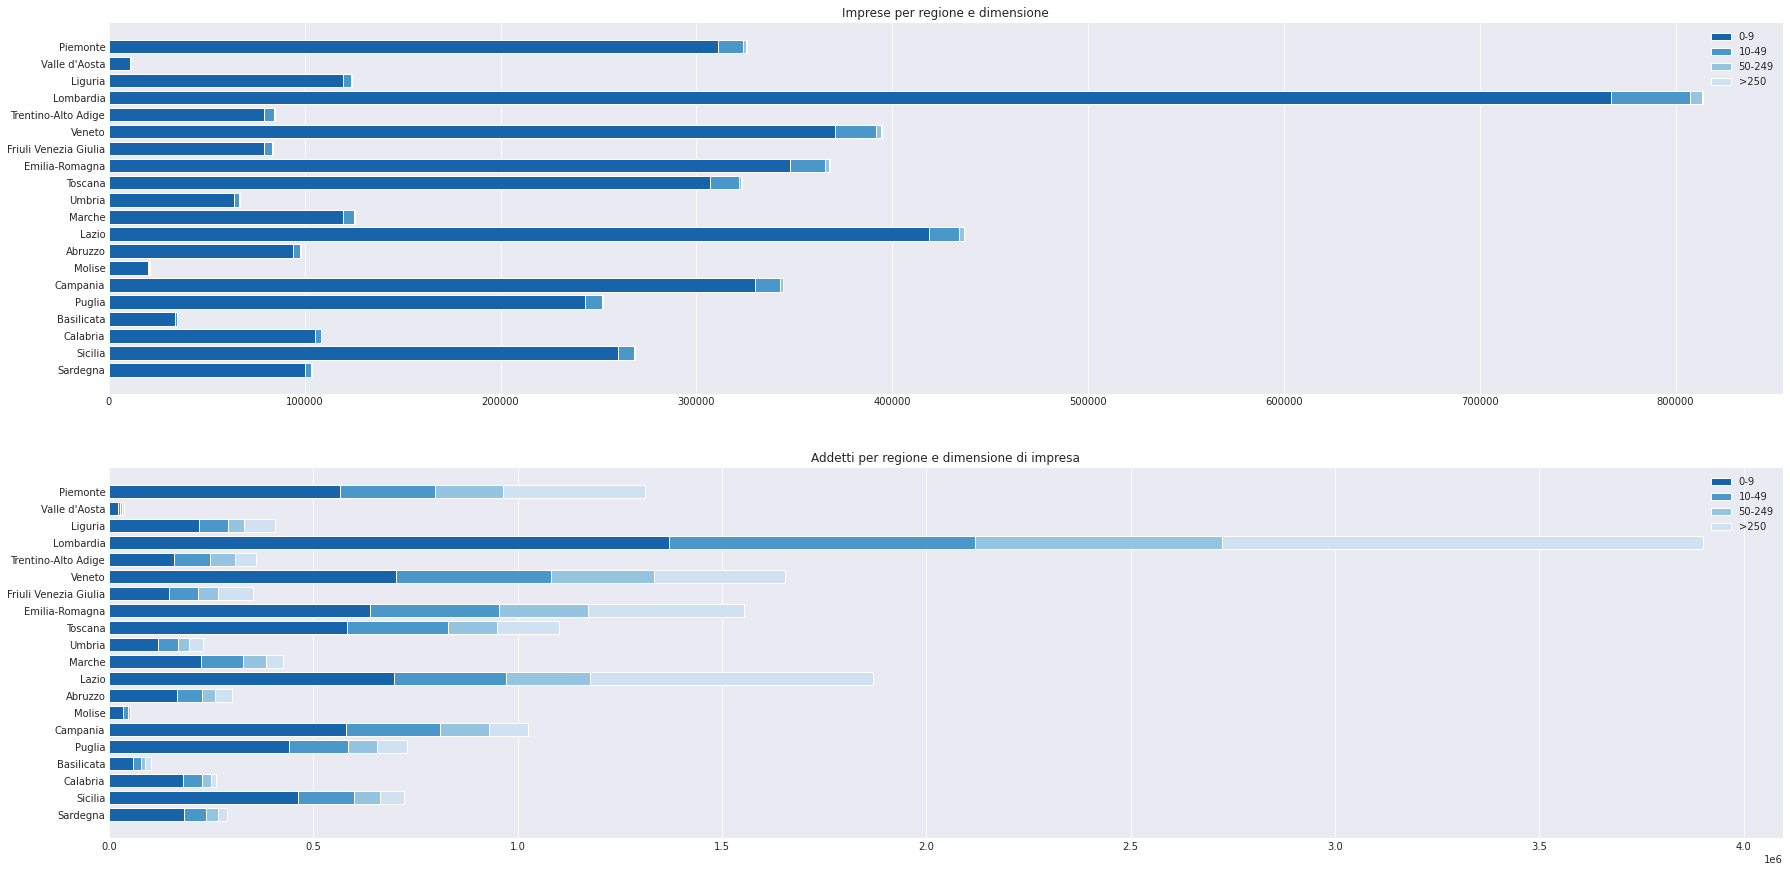

In [19]:
fig = plt.figure(figsize=(30,15))

# plotto le imprese
plt.subplot(2,1,1)
z_old = np.array(20*[0])

for i,col in enumerate(imprese_treg.columns[:4]):
    z = imprese_treg[col]

    plt.barh(imprese_treg.index, z, color=grad_b[4-i], edgecolor='white', align='center', left=z_old)
    z_old += z
    
plt.gca().invert_yaxis()
plt.legend(['0-9','10-49','50-249','>250'])
plt.grid(axis="x")
plt.title("Imprese per regione e dimensione")

# plotto gli addetti
plt.subplot(2,1,2)
z_old = np.array(20*[0])

for i,col in enumerate(imprese_treg.columns[4:]):
    z = imprese_treg[col]

    plt.barh(imprese_treg.index, z, color=grad_b[4-i], edgecolor='white', align='center', left=z_old)
    z_old += z
    
plt.gca().invert_yaxis()
plt.legend(['0-9','10-49','50-249','>250'])
plt.grid(axis="x")
plt.title("Addetti per regione e dimensione di impresa")

plt.show()

# Composizione famiglie

In [20]:
household = pickle.load(open( "data/comp_famiglie_rip_geo.pickle","rb"))

In [21]:
def family_to_vec(hs):
    col = hs.columns
    
    n_fam = len(hs)
    n_per = sum(hs.sum())
    
    a = hs[col[:6]].sum(axis=1).values>0
    b = hs[col[6:]].sum(axis=1).values>0
    
    c = hs[col[:6]].sum(axis=1).values
    d = hs[col[6:]].sum(axis=1).values
    
    return n_per/n_fam, (sum(a*b))/n_fam, sum(c)/n_fam, sum(d)/n_fam

In [22]:
vec = []

for rip_geo in set(household.rip_geo):
    hs = household[household["rip_geo"]==rip_geo][household.columns[:-1]]
    vec.append(family_to_vec(hs))
    
vec = np.array(vec)

In [23]:
ages = pd.DataFrame()
gb = household.groupby(["rip_geo"]).sum()


ages["0_19"] = gb.a_0_9 + gb.a_10_19 
ages["20_39"] = gb.a_20_29 + gb.a_30_39 
ages["40_59"] = gb.a_40_49 + gb.a_50_59 
ages["60_79"] = gb.a_60_69 + gb.a_70_79 
ages["80+"] = gb.a_80

ages = ages.values

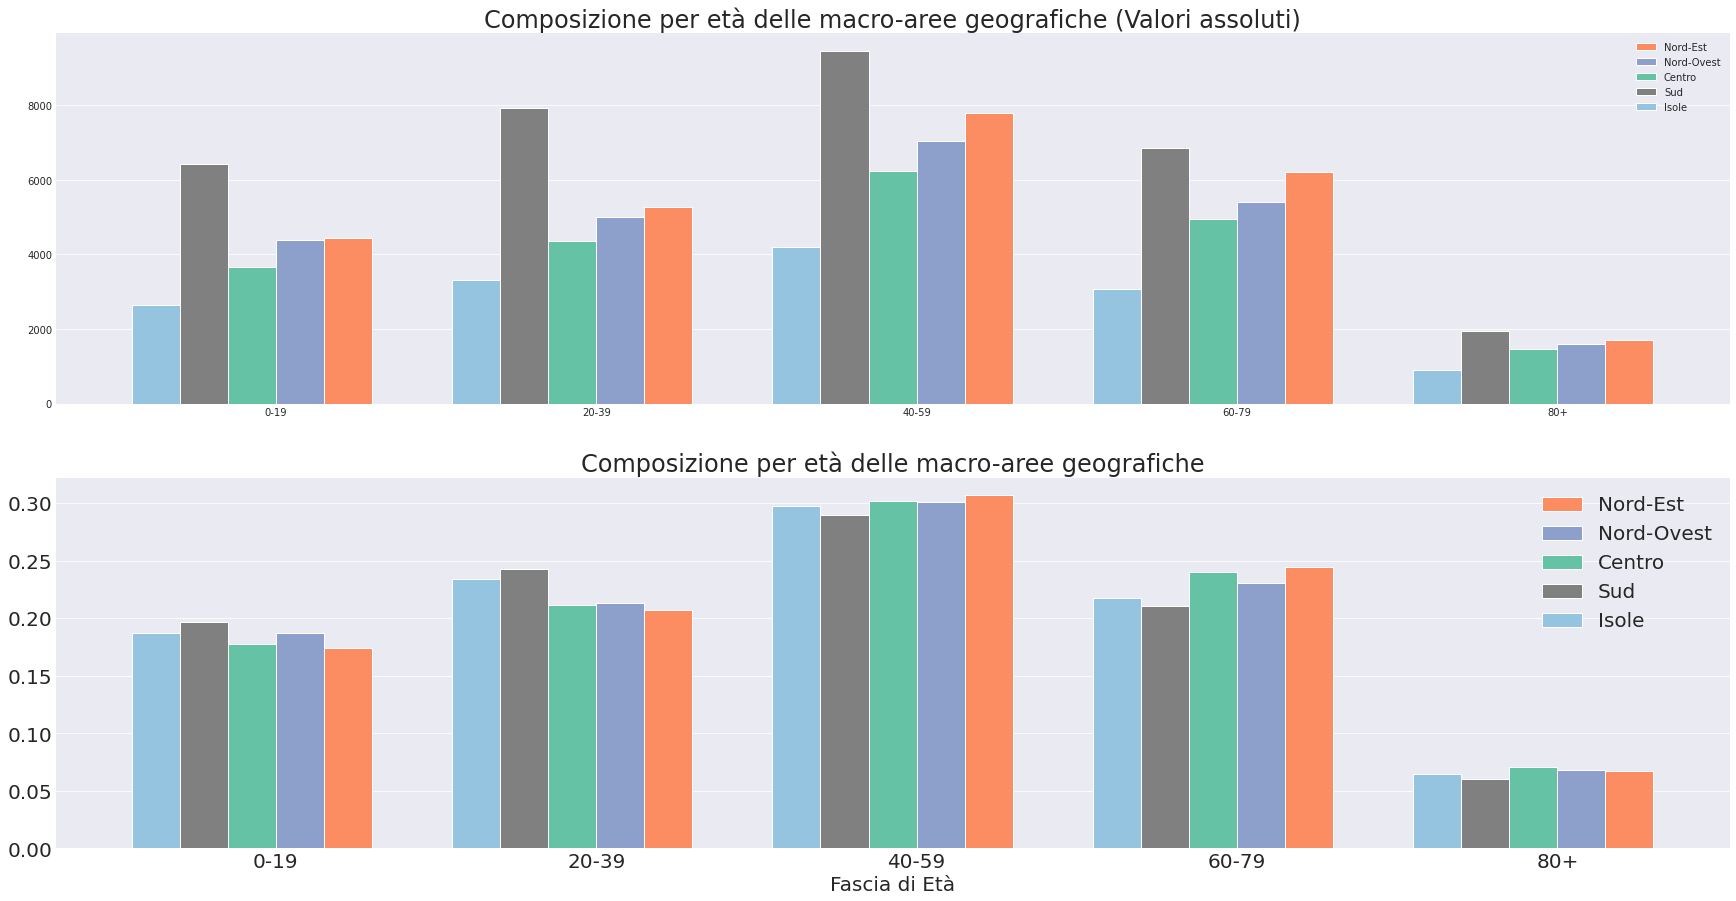

In [24]:
colors = ['#fc8d62','#8da0cb','#66c2a5','grey', grad_b[2]]

xax = []
for i in range(4):
    xax.append(str(0+20*i)+"-"+str(19+20*i))
xax.append("80+")

fig = plt.figure(figsize=(30,15))
width = 0.15
x = np.arange(5)

plt.subplot(2,1,1)
for i in range(5):
    plt.bar(x-width*(i-1), ages[i], width=width, color=colors[i], edgecolor='white', align='edge')

    plt.xticks(x, xax, ha='center')    
plt.legend(['Nord-Est','Nord-Ovest','Centro','Sud','Isole'],loc="upper right")
plt.grid(axis="y")
plt.rcParams.update({'font.size': 20})
plt.title("Composizione per età delle macro-aree geografiche (Valori assoluti)")

plt.subplot(2,1,2)
for i in range(5):
    plt.bar(x-width*(i-1), ages[i]/ages[i].sum(), width=width, color=colors[i], edgecolor='white', align='edge')
    
plt.xticks(x, xax, ha='center')
plt.legend(['Nord-Est','Nord-Ovest','Centro','Sud','Isole'],loc="upper right")
plt.grid(axis="y")
plt.rcParams.update({'font.size': 20})
plt.xlabel("Fascia di Età")
plt.title("Composizione per età delle macro-aree geografiche")

plt.show()

# Elenco delle fonti di origine dei dataset

- `Traffico_aereo_nazionale_2017_it.csv`: Rapporto ENAC 2017, voli passeggeri nazionali con piÃ¹ di 50000 passeggeri l'anno:<br>https://www.enac.gov.it/sites/default/files/allegati/2018-Ago/Dati_di_Traffico_2017_it.pdf

- `linee_pendolari_2017`: Rapporto Legambiente 2017 sulle tratte pendolari, linee con piÃ¹ di 20000 passeggeri al giorno:<br>https://www.legambiente.it/sites/default/files/docs/rapporto_pendolaria_2017.pdf

- Dati ISTAT 2018 sulla scuola:<br>http://dati.istat.it/Index.aspx?DataSetCode=DCIS_SCUOLE# <br>Sono comprese le tabelle
  - `scuole_classi_infanzia.csv`;  
  - `scuole_classi_primaria.csv`;
  - `scuole_classi_secondariaI.csv`;  
  - `scuole_classi_secondariaII.csv`;
  - `scuole_classi_totale.csv`;

- Dati ISTAT 2016 sulle aziende italiane:<br>https://www.istat.it/it/files//2018/12/C14.pdf <br>Sono comprese le tabelle
  - `imprese_regione.csv`;
  - `imprese_settore.csv`;
  - `imprese_taglia_regione.csv`;
  - `imprese_taglia_settore.csv`;